We import the necessary libraries and load the example dataset, which consists of the reviews of IMDB



## IMDB text analysis: NLP Final Project

Introduction : For the NLP course we are working with theIMDb Reviews Dataset for a sentiment anaysis task using topic modelling with Latent Dirichlet Allocation and Bert Transformer. We compare the two models to see the differences.


The objective of this project is to perform a comparative study of sentiment analysis on the IMDb Reviews Dataset using two distinct NLP paradigms. While standard sentiment analysis simply classifies a review as "positive" or "negative," we are integrating Topic Modeling to understand what users are talking about when they express those sentiments.


1. Latent Dirichlet Allocation (LDA)
LDA is a "Bag-of-Words" (BoW) probabilistic model. It assumes that every movie review is a mixture of various latent topics, and every topic is a mixture of words.

How it works: It ignores word order and focuses on frequency. For example, if a review contains words like "cinematography," "visuals," and "lighting," LDA clusters them into a "Technical/Visual" topic.

The Challenge: Since LDA doesn't understand context (e.g., the difference between "not good" and "good"), it is typically used as a feature extractor. You find the topics first, then see which topics correlate with positive or negative ratings.



2. BERT Transformer (Bidirectional Encoder Representations)
BERT represents the state-of-the-art in NLP. Unlike LDA, BERT is "context-aware"—it reads the entire sequence of words at once using an Attention Mechanism.

How it works: BERT creates dense vector embeddings. It understands that "The acting was a show-stopper" (positive) is different from "The show was a disaster" (negative), even though they share the word "show."

Topic Modeling with BERT: In this project, you are likely using BERTopic or extracting embeddings to cluster reviews. This allows for "Semantic Topic Modeling," where reviews are grouped by meaning rather than just keyword overlap.

## Importing necessary libraries



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [7]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [2]:
# Load and prepare the dataset
imdb_df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
#set style
imdb_df.head()

print(f"Full data set : {len(imdb_df)}")


Full data set : 50000


## Creating a stratified sample of the dataset

Since the dataset is more than 50k reviews we want to be able to review a smaller subset

In [3]:
# Create a stratified sample of 25,000 reviews
# Stratified means we keep the same proportion of positive and negative reviews as the original

imdb_df_25 = (
    imdb_df
    .groupby('sentiment', group_keys=False)
    .sample(n=12_500, random_state=42)
    .reset_index(drop=True)
)

# Verification prints
print(f"Subsample size: {len(imdb_df_25)}")
print(imdb_df_25['sentiment'].value_counts())



Subsample size: 25000
sentiment
negative    12500
positive    12500
Name: count, dtype: int64


Training - Test Split

In [8]:
# Splitting the 25k sample into training and testing sets
train_df, test_df = train_test_split(
    imdb_df_25, # The input dataframe
    test_size=0.2, # 20% of data goes to testing (5,000), 80% to training (20,000)
    
    # Ensures both train and test sets have an equal 50/50 split of pos/neg reviews
    stratify=imdb_df_25['sentiment'],
    
    # Guarantees the same split every time the code is executed
    random_state=42
)
# .copy() creates a deep copy of the dataframes
# This prevents "SettingWithCopyWarning" errors when when we start cleaning the text
train_df = train_df.copy()
test_df = test_df.copy()

# Summary statistics to confirm the split was successful

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Label distribution (train): {train_df['sentiment'].value_counts().to_dict()}")


Training samples: 20000
Test samples: 5000
Label distribution (train): {'positive': 10000, 'negative': 10000}


Feature Engineering

In [9]:
# 1. Type Casting
# Ensures all entries in the 'review' column are strings. 
# This prevents errors during text processing if there are accidental 'None' or numeric values.
train_df['review'] = train_df['review'].astype(str)
test_df['review'] = test_df['review'].astype(str)

# 2. Feature Creation: Character Length
# Calculates the total number of characters (including spaces and punctuation) for each review.
# This helps identify outliers (extremely short or extremely long reviews).

train_df['char_length'] = train_df['review'].apply(len)
test_df['char_length'] = test_df['review'].apply(len)

# 3. Statistical Analysis
# Generates summary statistics (mean, median, min, max, and quartiles) for the review lengths.


train_df['char_length'].describe()


count    20000.000000
mean      1305.914300
std        979.235485
min         41.000000
25%        700.000000
50%        969.000000
75%       1596.000000
max      12129.000000
Name: char_length, dtype: float64

In [10]:
# 1. Word Count Calculation (Tokenization)
# This uses a lambda function to split the string by whitespace (x.split()) 
# and counts the resulting number of words.

train_df['token_length'] = train_df['review'].apply(lambda x: len(x.split()))
test_df['token_length'] = test_df['review'].apply(lambda x: len(x.split()))


# 2. Distribution Summary
# Provides statistical insights (mean, min, max, etc.) into the word counts 
# of the training set.


train_df['token_length'].describe()


count    20000.000000
mean       230.505900
std        169.531966
min          4.000000
25%        127.000000
50%        173.000000
75%        281.000000
max       2125.000000
Name: token_length, dtype: float64

In [11]:
# Grouping the data by 'sentiment' (Positive vs. Negative)
# and selecting the two numerical length columns for analysis

train_df.groupby('sentiment')[['char_length', 'token_length']].describe()


char_length                                                        \
                count       mean          std   min     25%    50%      75%   
sentiment                                                                     
negative      10000.0  1295.3701   947.188019  41.0  708.00  971.5  1587.25   
positive      10000.0  1316.4585  1010.204259  65.0  691.75  967.0  1608.25   

                   token_length                                            \
               max        count      mean         std   min    25%    50%   
sentiment                                                                   
negative    7761.0      10000.0  229.6343  164.886222   4.0  128.0  174.0   
positive   12129.0      10000.0  231.3775  174.057644  10.0  124.0  171.5   

                          
             75%     max  
sentiment                 
negative   281.0  1376.0  
positive   281.0  2125.0

## Exploratory Data Analysis

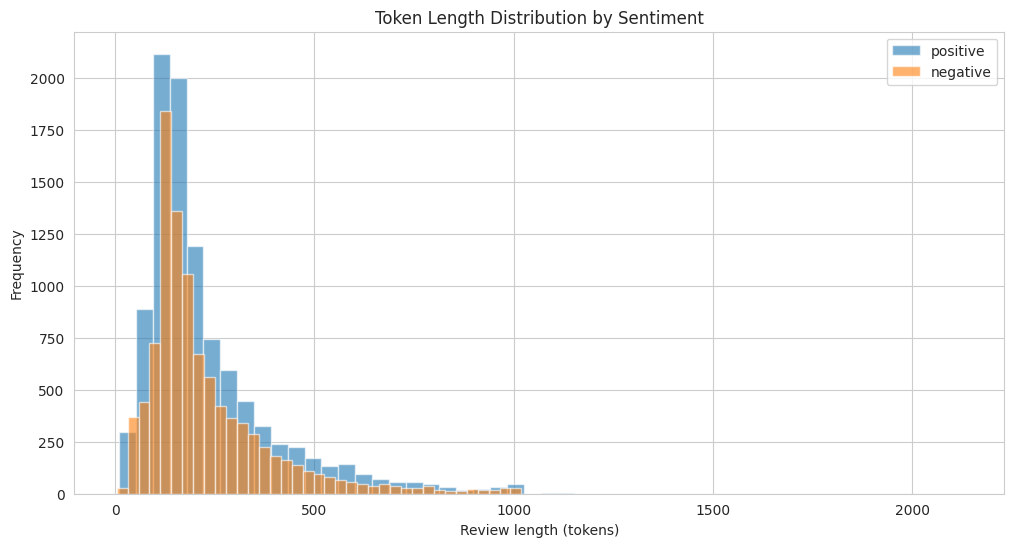

In [12]:
# 1. Iterate through each unique sentiment label (Positive and Negative)

for label in train_df['sentiment'].unique():
    subset = train_df[train_df['sentiment'] == label]
    
    # 2. Generate the histogram for the current sentiment
    # bins=50: Divides the data into 50 bars for better granularity
    # alpha=0.6: Makes the bars semi-transparent so you can see where they overlap
    # label=label: Sets the name for the legend (e.g., 'pos' or 'neg')
    
    plt.hist(subset['token_length'], bins=50, alpha=0.6, label=label)

# 3. Plot Aesthetics

plt.xlabel("Review length (tokens)") # X-axis shows the number of words
plt.ylabel("Frequency") # Y-axis shows how many reviews fall into that length
plt.title("Token Length Distribution by Sentiment") 
plt.legend() # Displays the color key for 'positive' vs 'negative'
plt.show() # Renders the final visualization


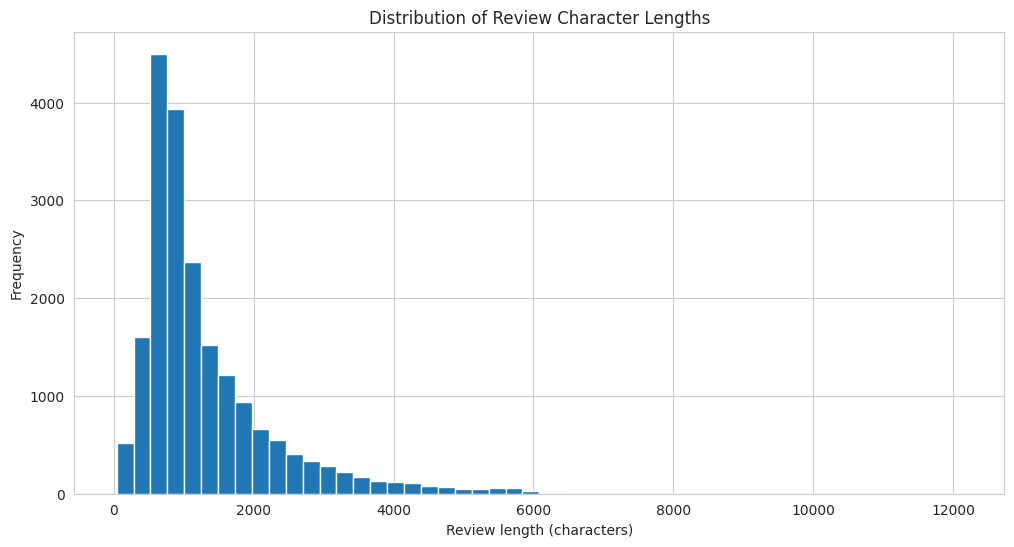

In [13]:
# 1. Plotting the Histogram
# Takes the 'char_length' column and groups the values into 50 "bins" (vertical bars).
# This provides a high-level view of the dataset's density—where most reviews cluster.

plt.hist(train_df['char_length'], bins=50)

# 2. Labeling the X-axis
# Represents the total number of characters in a single review string.

plt.xlabel("Review length (characters)")

# 3. Labeling the Y-axis
# Represents the count (frequency) of reviews that fall within each length bin.

plt.ylabel("Frequency")

# 4. Chart Title

plt.title("Distribution of Review Character Lengths")

# 5. Rendering the Plot

plt.show()


## Model 1 : Latent Dirichlet Allocation

In [14]:
# 1. Initialize the CountVectorizer
# This tool converts text into a matrix of token counts (Bag-of-Words).
count_vectorizer = CountVectorizer(
    max_df=0.95,        # ignore very common words that appear more than 95% of the reviews
    min_df=10,          # ignore very rare words that appear in less than 10 reviews
    stop_words='english',#removing filler words (e.g., "the", "and", "is").
    max_features=10_000 # Limit the vocabulary to the top 10,000 most frequent words.
)

# 2. Fit and Transform the Training Data
# 'fit' learns the vocabulary; 'transform' converts the reviews into the count matrix.

train_bow = count_vectorizer.fit_transform(train_df['review'])

# 3. Shape Verification
# The output will be (number_of_reviews, max_features), likely (20000, 10000).

print("Bag-of-Words shape:", train_bow.shape)


Bag-of-Words shape: (20000, 10000)


## Hyperparameter tuning and model initialization

In [15]:
# 1. Hyperparameter Setting
# We tell the model to find 20 distinct themes/topics across the dataset.
# In a course project, choosing this number is often done by trial and error.

n_topics = 20

# 2. Model Initialization

lda = LatentDirichletAllocation(
    n_components=n_topics, # Number of topics to be extracted
    random_state=42,

    # 'batch' means the model looks at all reviews together to update topics.
    # This is more accurate but slower than 'online' (incremental) learning.
    
    learning_method='batch',
    max_iter=10
)

# 3. Training and Transformation
# 'fit' learns the word-topic distributions.
# 'transform' calculates the topic-mixture for each individual review.

document_topic_matrix = lda.fit_transform(train_bow)

# 4. Shape Verification
# Resulting shape: (20000 reviews, 20 topics).
# Each row represents one review and shows the probability (0.0 to 1.0) of belonging to each topic.

print("Document–Topic matrix shape:", document_topic_matrix.shape)


Document–Topic matrix shape: (20000, 20)


## Constructing the topic dataframe 

In [16]:
# 1. Constructing the Topic DataFrame

doc_topic_df = pd.DataFrame(

    # The raw matrix of probabilities (20,000 rows x 20 topics)
    
    document_topic_matrix,
    
    # Creates dynamic column headers: 'topic_0', 'topic_1', ..., 'topic_19'
    
    columns=[f"topic_{i}" for i in range(n_topics)],

    # Matches the row IDs to your original training dataframe 
    # This is vital so you can later join the 'sentiment' labels back to these topics

    index=train_df.index
)

# 2. Previewing the Data
# Displays the first 5 rows to verify that each review now has a 
# distribution of probabilities across the 20 topics.

doc_topic_df.head()


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
20022,0.000463,0.049739,0.000463,0.000463,0.086743,0.000463,0.000463,0.216914,0.168439,0.000463,0.000463,0.000463,0.000463,0.000463,0.000463,0.247509,0.000463,0.000463,0.000463,0.224174
4993,0.000610,0.295018,0.000610,0.000610,0.000610,0.000610,0.000610,0.000610,0.157503,0.000610,0.125928,0.000610,0.000610,0.000610,0.000610,0.000610,0.000610,0.000610,0.104899,0.307506
24760,0.157838,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.233920,0.000806,0.000806,0.360006,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.235332
13775,0.054358,0.000287,0.000287,0.000287,0.062635,0.000287,0.021474,0.000287,0.000287,0.229539,0.000287,0.000287,0.000287,0.000287,0.000287,0.031699,0.056614,0.215652,0.000287,0.324580
20504,0.001923,0.162263,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.135077,0.196558,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.475332,0.001923


## Transposing LDA components

In [18]:
# Transpose the LDA components
# lda.components_ has a shape of (n_topics, n_words). 
# We transpose it (.T) so that words become rows and topics become columns.


term_topic_matrix = lda.components_.T

# 2. Convert raw counts to probabilities (Normalization)
# This ensures that for each topic (column), the values sum to 1.
# It allows us to say: "In Topic 0, the word 'scary' has a 5% probability of appearing."term_topic_matrix = term_topic_matrix / term_topic_matrix.sum(axis=0, keepdims=True)
term_topic_matrix = term_topic_matrix / term_topic_matrix.sum(axis=0, keepdims=True)

# 3. Create a Structured DataFrame

term_topic_df = pd.DataFrame(
    term_topic_matrix,
    index=count_vectorizer.get_feature_names_out(),
    columns=[f"topic_{i}" for i in range(n_topics)]
)

term_topic_df.head()


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
00,4.132773e-05,8.089263e-07,0.000001,0.000094,0.000132,3.509736e-06,0.000202,6.807445e-07,5.596180e-07,5.446923e-07,1.206639e-05,5.256572e-07,7.542237e-07,0.000313,3.582409e-07,0.000001,9.397578e-07,1.559361e-04,2.656493e-07,2.238573e-04
000,5.472156e-07,3.444002e-04,0.000143,0.000018,0.000002,2.449053e-04,0.000007,3.911618e-04,2.150463e-05,1.510524e-04,3.451890e-04,2.631318e-05,1.095129e-06,0.000250,1.181973e-05,0.000006,5.530887e-05,1.052164e-04,3.682271e-05,4.040154e-05
007,5.466689e-07,8.089262e-07,0.000001,0.000001,0.001333,2.505355e-07,0.000001,6.807444e-07,5.596179e-07,5.446923e-07,2.245345e-07,5.256572e-07,7.542237e-07,0.000001,3.582409e-07,0.000001,3.921568e-07,3.735901e-07,2.656493e-07,3.108242e-07
10,6.493797e-04,1.429429e-04,0.003871,0.001706,0.003177,1.799450e-03,0.000648,4.775895e-04,1.447477e-03,2.493169e-03,1.009123e-03,7.466905e-04,8.878832e-04,0.000154,2.014143e-03,0.001025,1.572245e-03,1.256507e-03,2.125954e-04,7.394108e-03
100,5.513525e-06,1.507763e-04,0.000257,0.000001,0.000002,2.894662e-04,0.000167,4.374870e-04,1.238951e-04,2.379973e-05,3.271383e-04,1.312090e-05,2.547552e-04,0.000156,1.165482e-04,0.000008,2.176424e-05,2.277376e-04,6.624026e-05,5.309216e-04


## Word Extraction

In [19]:
# 1. Define a function to extract the most important words for each topic

def display_topics(model, feature_names, n_top_words=10):
    # Iterate through the topics stored in the model's components
    for topic_idx, topic in enumerate(model.components_):

        # topic.argsort() returns indices that would sort the array. 
        # [:-n_top_words - 1:-1] slices the array to get the top 'n' indices in descending order.
        print(f"\nTopic {topic_idx}:")
        print(" ".join([
            feature_names[i]
            for i in topic.argsort()[:-n_top_words - 1:-1]
        ]))

# 2. Retrieve the vocabulary list (words) from our vectorizer

feature_names = count_vectorizer.get_feature_names_out()

# 3. Print the top 10 keywords for each of the 20 topics

display_topics(lda, feature_names, n_top_words=10)

# 4. Merging Topics with Sentiment Labels
# We combine the topic probabilities (doc_topic_df) and the actual sentiment (train_df)
# axis=1 ensures they are joined side-by-side as columns.

topic_sentiment_df = pd.concat(
    [doc_topic_df, train_df['sentiment']],
    axis=1
)

# 5. Statistical Correlation Analysis
# We group by 'sentiment' and calculate the average probability of each topic.
# .T transposes the result so topics are rows, making it easier to compare Pos vs Neg.

topic_sentiment_df.groupby('sentiment').mean().T.head(10)


Topic 0:
br film story wife life character man love father mother

Topic 1:
br war series american western john man later james police

Topic 2:
br good like match great time charlie watch new just

Topic 3:
film war movie best performance time series story great acting

Topic 4:
tony game film like eddie br bond harry original sean

Topic 5:
br movie bad like just film good really guy don

Topic 6:
episode funny br comedy time series love just season episodes

Topic 7:
film films music time br documentary like people short work

Topic 8:
film movie book br great story good version character read

Topic 9:
br movie good great best character film time man little

Topic 10:
br film movie people just like time story know make

Topic 11:
movie like film really good people think just kids great

Topic 12:
film comedy movie funny great good just cast like br

Topic 13:
br man dance young kelly film dancing love woman life

Topic 14:
br movie film story like characters just action good reall

sentiment,negative,positive
topic_0,0.024769,0.054953
topic_1,0.019325,0.031829
topic_2,0.015404,0.025379
topic_3,0.011864,0.032641
topic_4,0.012619,0.013909
topic_5,0.141896,0.028980
topic_6,0.018417,0.031687
topic_7,0.029196,0.044574
topic_8,0.034414,0.072213
topic_9,0.038426,0.053112


## Merging topics with sentiment labels

In [21]:
# Merging Topics with Sentiment Labels
# We use pd.concat to join the document-topic probability matrix with the original sentiment column.
# [doc_topic_df, train_df['sentiment']] - The two objects to join.
# axis=1 - Joins them side-by-side (columns) rather than stacking them (rows).

topic_sentiment_df = pd.concat(
    [doc_topic_df, train_df['sentiment']],
    axis=1
)
# 2. Calculating Sentiment-Topic Correlation
# .groupby('sentiment') - Splits the data into "positive" and "negative" buckets.
# .mean() - Calculates the average probability for every topic within those buckets.
# .T - Transposes the table so Topics are rows and Sentiments are columns (easier to read).
# .head(10) - Displays the first 10 topics for a quick comparison.

topic_sentiment_df.groupby('sentiment').mean().T.head(10)


sentiment,negative,positive
topic_0,0.024769,0.054953
topic_1,0.019325,0.031829
topic_2,0.015404,0.025379
topic_3,0.011864,0.032641
topic_4,0.012619,0.013909
topic_5,0.141896,0.028980
topic_6,0.018417,0.031687
topic_7,0.029196,0.044574
topic_8,0.034414,0.072213
topic_9,0.038426,0.053112


## Cleaning and averaging dominant topics

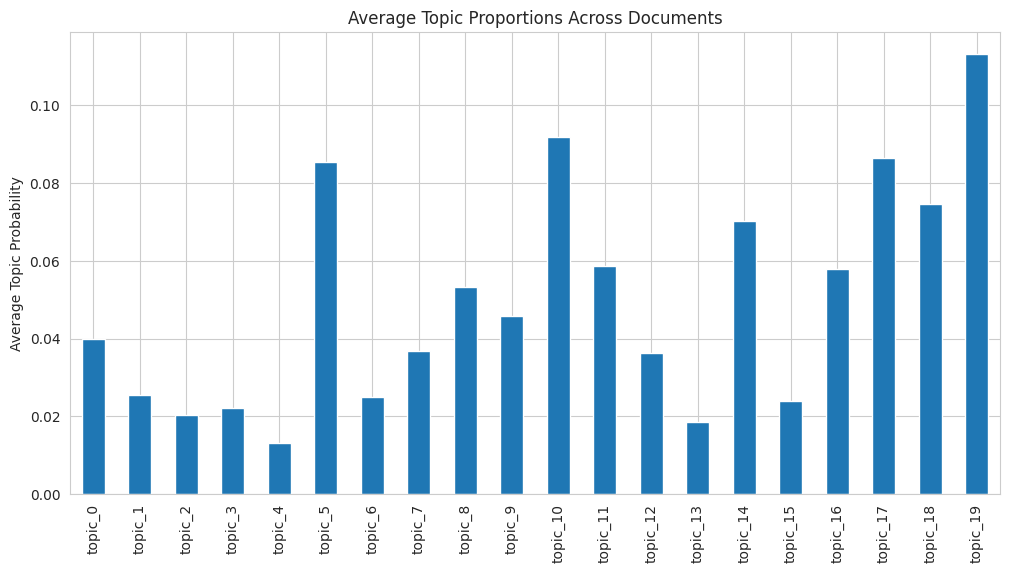

In [22]:
# 1. Cleaning and Averaging
# .drop(...) ensures that the 'dominant_topic' column (which is text) is removed 
# so the computer only tries to calculate the average of the numerical probability columns.
# errors='ignore' prevents the code from crashing if the column doesn't exist yet.
# .mean() calculates the average probability for each topic across all 20,000 reviews.


doc_topic_df.drop(columns='dominant_topic', errors='ignore').mean().plot(
    kind='bar',
    title='Average Topic Proportions Across Documents'
)

# 2. This represents the mean probability (weight) of the topic in the corpus.
plt.ylabel("Average Topic Probability")

# 3. Displaying the Plot

plt.show()


In [23]:
# 1. Create a Deep Copy
# We create a new DataFrame based on doc_topic_df to avoid 
# modifying the original topic distribution data.


topic_sentiment_df = doc_topic_df.copy()


# 2. Aligning the Labels
# We add the 'sentiment' column from our original training data.
# .values is used to ensure we are grabbing the raw data; since we 
# reset the index earlier, this ensures the 20,000 labels align 
# perfectly with the 20,000 topic rows.

topic_sentiment_df['sentiment'] = train_df['sentiment'].values

# 3. Preview the Combined Data
# You will now see 'topic_0' through 'topic_19' followed by 
# a final column indicating if that review was 'positive' or 'negative'.


topic_sentiment_df.head()


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,sentiment
20022,0.000463,0.049739,0.000463,0.000463,0.086743,0.000463,0.000463,0.216914,0.168439,0.000463,...,0.000463,0.000463,0.000463,0.000463,0.247509,0.000463,0.000463,0.000463,0.224174,positive
4993,0.000610,0.295018,0.000610,0.000610,0.000610,0.000610,0.000610,0.000610,0.157503,0.000610,...,0.000610,0.000610,0.000610,0.000610,0.000610,0.000610,0.000610,0.104899,0.307506,negative
24760,0.157838,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.233920,0.000806,...,0.360006,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.235332,positive
13775,0.054358,0.000287,0.000287,0.000287,0.062635,0.000287,0.021474,0.000287,0.000287,0.229539,...,0.000287,0.000287,0.000287,0.000287,0.031699,0.056614,0.215652,0.000287,0.324580,positive
20504,0.001923,0.162263,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,...,0.196558,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.475332,0.001923,positive


In [24]:
# 1. Group and Aggregate
# We take our master DataFrame and group all rows by their sentiment label ('positive'/'negative').

topic_means_by_sentiment = (
    topic_sentiment_df

    # 2. Calculate the Mean
    # This finds the average probability of each topic within those groups.
    # For example, it shows if 'Topic 5' appears more strongly in negative reviews.
    
    .groupby('sentiment')
    .mean()
)

# 3. Display the Result
topic_means_by_sentiment


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
sentiment,,,,,,,,,,,,,,,,,,,,
negative,0.024769,0.019325,0.015404,0.011864,0.012619,0.141896,0.018417,0.029196,0.034414,0.038426,0.115169,0.048980,0.029460,0.014162,0.047035,0.027962,0.058049,0.146521,0.041400,0.124931
positive,0.054953,0.031829,0.025379,0.032641,0.013909,0.028980,0.031687,0.044574,0.072213,0.053112,0.068785,0.068516,0.043011,0.023137,0.093513,0.019729,0.058038,0.026669,0.107885,0.101440


In [25]:
# 1. Calculate the Differential
# We subtract the average probability of a topic in negative reviews 
# from its average probability in positive reviews.
topic_diff = (
    topic_means_by_sentiment.loc['positive'] 
    - topic_means_by_sentiment.loc['negative']
)

# 2. Sort the Results
# Sorting in descending order places the most "Positive" topics at the top 
# and the most "Negative" topics at the bottom.
# ascending=False: highest positive values first.
topic_diff = topic_diff.sort_values(ascending=False)

# 3. Display the Series
# This returns a list of topics with values typically ranging between -1 and 1.
topic_diff

topic_18    0.066485
topic_14    0.046477
topic_8     0.037798
topic_0     0.030185
topic_3     0.020777
topic_11    0.019536
topic_7     0.015378
topic_9     0.014686
topic_12    0.013551
topic_6     0.013270
topic_1     0.012504
topic_2     0.009975
topic_13    0.008975
topic_4     0.001290
topic_16   -0.000011
topic_15   -0.008234
topic_19   -0.023491
topic_10   -0.046384
topic_5    -0.112916
topic_17   -0.119852
dtype: float64

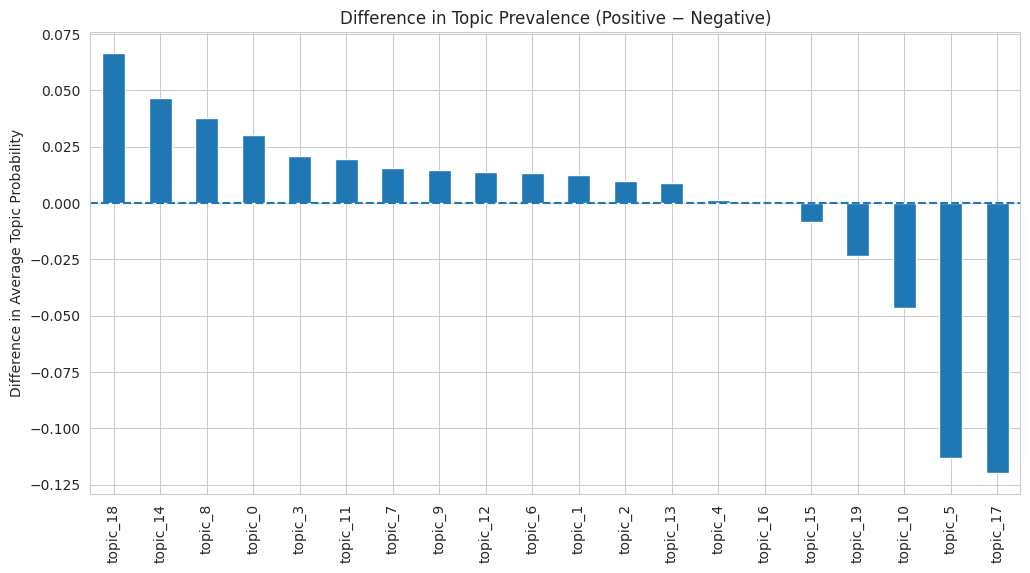

In [26]:
# 1. Plotting the Differences
# Uses the 'topic_diff' series created in the previous step.
# Since the data is already sorted, the bars will show a clear trend 
# from the most positive topics to the most negative ones.

topic_diff.plot(
    kind='bar',
    title='Difference in Topic Prevalence (Positive − Negative)'
)


# 2. Adding a Baseline (Neutral Line)
# plt.axhline(0, ...) draws a horizontal line at y = 0.
# linestyle='--' makes it dashed.
# This serves as the "neutral" boundary; topics near this line are sentiment-neutral.

plt.axhline(0, linestyle='--')

plt.ylabel("Difference in Average Topic Probability")

# 3. Final Render
plt.show()


BERT



In [ ]:
!pip install bertopic sentence-transformers umap-learn hdbscan
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import numpy as np


In [ ]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")


In [ ]:
topic_model = BERTopic(
    embedding_model=embedding_model,
    verbose=True,
    min_topic_size=50
)

topics, probs = topic_model.fit_transform(docs)


In [ ]:
bert_topic_df = pd.DataFrame({
    "topic": topics,
    "sentiment": sentiments
})

bert_topic_df.head()

#Remove outliers

bert_topic_df = bert_topic_df[bert_topic_df['topic'] != -1]


In [ ]:
#Topic Distribution by Sentiment (BERT)

topic_sentiment_counts = (
    bert_topic_df
    .groupby(['sentiment', 'topic'])
    .size()
    .unstack(fill_value=0)
)

topic_sentiment_counts


In [ ]:
# Normalize to proportions:

topic_sentiment_props = topic_sentiment_counts.div(
    topic_sentiment_counts.sum(axis=1), axis=0
)

topic_sentiment_props


In [ ]:
# Topic Polarization (Positive − Negative)

topic_diff_bert = (
    topic_sentiment_props.loc['positive']
    - topic_sentiment_props.loc['negative']
).sort_values(ascending=False)

topic_diff_bert


In [ ]:
# Visualize Topic Differences

topic_diff_bert.plot(
    kind='bar',
    title='BERT Topic Prevalence Difference (Positive − Negative)'
)

plt.axhline(0, linestyle='--')
plt.ylabel("Difference in Proportion")
plt.show()


In [ ]:
#Interpret Polarized BERT Topics

#Most positive-associated topics

top_pos_topics = topic_diff_bert.head(5).index.tolist()
top_neg_topics = topic_diff_bert.tail(5).index.tolist()


In [ ]:
#Inspect topic words

for topic_id in top_pos_topics:
    print(f"\nPositive Topic {topic_id}:")
    print(topic_model.get_topic(topic_id))


In [ ]:
for topic_id in top_neg_topics:
    print(f"\nNegative Topic {topic_id}:")
    print(topic_model.get_topic(topic_id))


In [ ]:
topic_model.visualize_barchart(top_n_topics=15)


In [ ]:
topic_model.visualize_topics()


In [ ]:
#Topic Word Importance (Per Topic)

topic_model.visualize_term_rank()


In [ ]:
import matplotlib.pyplot as plt

topic_sentiment_props.T.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 6)
)

plt.title("Topic Distribution by Sentiment (BERTopic)")
plt.xlabel("Topic")
plt.ylabel("Proportion")
plt.legend(title="Sentiment")
plt.show()


In [ ]:
#Visualizing Topic Polarity
topic_diff_bert.plot(
    kind='bar',
    figsize=(14, 6),
    title="Topic Polarity (Positive − Negative)"
)

plt.axhline(0, linestyle='--', color='black')
plt.ylabel("Difference in Topic Proportion")
plt.show()


In [ ]:
# lda VS BERT
topic_diff.plot(
    kind='bar',
    figsize=(14, 5),
    title="LDA Topic Polarity (Positive − Negative)"
)

plt.axhline(0, linestyle='--', color='black')
plt.ylabel("Difference in Average Topic Probability")
plt.xlabel("Topic")
plt.show()

topic_diff_bert.plot(
    kind='bar',
    figsize=(14, 5),
    title="BERT Topic Polarity (Positive − Negative)"
)

plt.axhline(0, linestyle='--', color='black')
plt.ylabel("Difference in Topic Proportion")
plt.xlabel("Topic")
plt.show()
